## Introduction

Can we predict sea surface temperatures into the future? What trends are there in sea surface temperatures that are bigger than a year? This notebook cleans and analyses data to answer these questions.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
sns.set_theme(style='whitegrid')
from scipy.signal import butter, filtfilt, welch
from sklearn.linear_model import LinearRegression

## Clean data

### The data

The climate data is over 80 years of daily sea surface temperature, wave height, and wind speed data from the North Pacific Ocean. The data has been queried from the [ERA5 Reanalysis Product](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview).

A reanalysis is a dataset that combines historical observations with a physics-based computer model of the earth system (which is not generally as accurate as a measurement, but can at least cover the entire world) to produce consistent yet large datasets. ERA5 is produced by the European Center for Medium-Range Weather Forecasting (ECMWF), widely regarded as the best forecasting center in the world. Therefore, it is the preferred data product for studying how the Earth's climate has evolved over the past century.

The variable we will be interested in using is sst, which is the sea surface temperature in Kelvin.


### Load the data

Load the climate data set

In [2]:
climate = pd.read_csv('https://github.com/Tres300/Climate/raw/main/north_pacific.csv')

### Explore the contents of the data sets

In [3]:
climate

,sst,u10,hsig,time,latitude,longitude
0,286.97070,0.612978,4.136298,1940-01-01 12:00:00,34.9,-165.0
1,286.97836,2.574189,2.759662,1940-01-02 12:00:00,34.9,-165.0
2,287.01630,2.623150,1.873087,1940-01-03 12:00:00,34.9,-165.0
3,287.02680,-1.868878,1.753748,1940-01-04 12:00:00,34.9,-165.0
4,287.03183,3.412738,2.692871,1940-01-05 12:00:00,34.9,-165.0
...,...,...,...,...,...,...
30736,287.42468,-9.920603,3.501683,2024-02-25 12:00:00,34.9,-165.0
30737,287.95334,-6.379527,2.745611,2024-02-26 12:00:00,34.9,-165.0
30738,287.92685,-2.907410,2.102718,2024-02-27 12:00:00,34.9,-165.0
30739,288.13498,-2.018521,1.651154,2024-02-28 12:00:00,34.9,-165.0


In [4]:
climate.describe()

,sst,u10,hsig,latitude,longitude
count,30741.000000,30741.000000,30741.000000,3.074100e+04,30741.0
mean,291.723484,1.462743,2.627334,3.490000e+01,-165.0
std,3.825816,6.038611,1.311026,7.105543e-15,0.0
min,284.794000,-18.708815,0.746870,3.490000e+01,-165.0
25%,288.351680,-3.112220,1.625169,3.490000e+01,-165.0
50%,290.842040,1.232235,2.302131,3.490000e+01,-165.0
75%,295.407650,5.660821,3.292069,3.490000e+01,-165.0
max,300.266850,24.724703,12.141653,3.490000e+01,-165.0


In [5]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30741 entries, 0 to 30740
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sst        30741 non-null  float64
 1   u10        30741 non-null  float64
 2   hsig       30741 non-null  float64
 3   time       30741 non-null  object 
 4   latitude   30741 non-null  float64
 5   longitude  30741 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


### Convert data types

Convert `time` to datetime

In [6]:
climate['time']=pd.to_datetime(climate.loc[:,'time'])

### Are there missing days?

In [7]:
climate.tail(1)['time'] - climate.head(1)['time']

0       NaT
30740   NaT
Name: time, dtype: timedelta64[ns]

There are 30740 days in between 1/1/1940 and 2/29/2024, while there are 30741 days in the dataset. So no missing days!

## Questions

The following are the questions that will be attempted to be answered by this notebook:
* Can we predict sea surface temperatures into the future?
* What trends are there in sea surface temperatures that are bigger than a year?


## Analysis

### Calculate discrete fourier transform of sea surface temperatures

In [8]:
sst = climate["sst"].values
n = len(sst)  # Total length
t = np.arange(n)  # Daily data, so the time vector starts at 0 and ends at n - 1
dt = t[1] - t[0]  # Sampling interval dt = 1 day
fs = 1 / dt  # Sampling frequency fs = 1 sample/day (often abbreviated cpd for cycles per day)
f0 = (1 / n) / dt  # Frequency resolution
p = int((n - 1) / 2)

a = np.zeros((p + 1,))
b = np.zeros((p + 1,))
frequency = np.zeros((p + 1,))

for idx, j in enumerate(range(p + 1)):
    a[j] = (2 / n) * np.sum(sst * np.cos(2 * np.pi * f0 * j * t))
    b[j] = (2 / n) * np.sum(sst * np.sin(2 * np.pi * f0 * j * t))
    frequency[idx] = f0 * j
a[0] = a[0] / 2

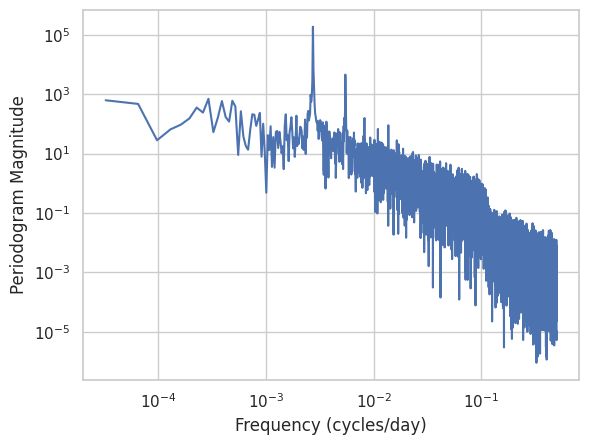

In [9]:
# Calculating the discrete fourier transform using Numpy's FFT implementation
dft = np.fft.fft(sst)[:p + 1]
P_from_dft = (np.real(dft)**2 + np.imag(dft)**2) / n

# Plot the result
fig, ax = plt.subplots()
ax.plot(frequency[1:], P_from_dft[1:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

###What are those two highest peaks?

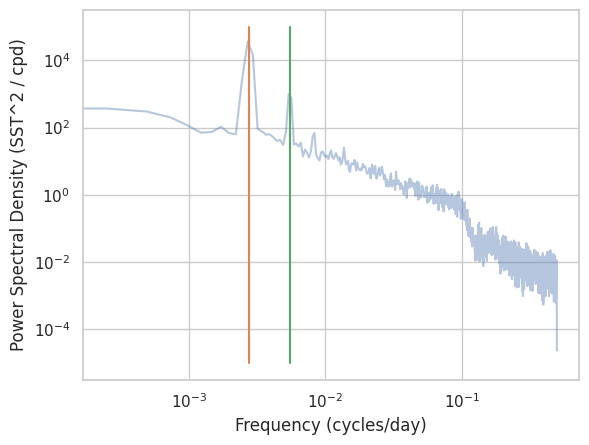

In [10]:
# Guess and check lines
x_year = np.array([1/365 for _ in range(3)])
x_season = np.array([1/183 for _ in range(3)])
y = np.array([10**-5, 1, 10**5])

# Plot the power spectral density so identifying the largest trends is easier
f, Pw = welch(sst, fs=1.0, window="hamming", nperseg=4096)
fig, ax = plt.subplots()
ax.plot(f, Pw, alpha=0.4)
ax.plot(x_year, y)
ax.plot(x_season, y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Power Spectral Density (SST^2 / cpd)")
plt.show()

Using some good ol' guess and check, the most prominent frequencies are a year and half a year. Who would have guessed?

###Apply low-pass butterworth filter with cutoff of a year
We're only interested in trends bigger than a year, so let's get rid of noise.

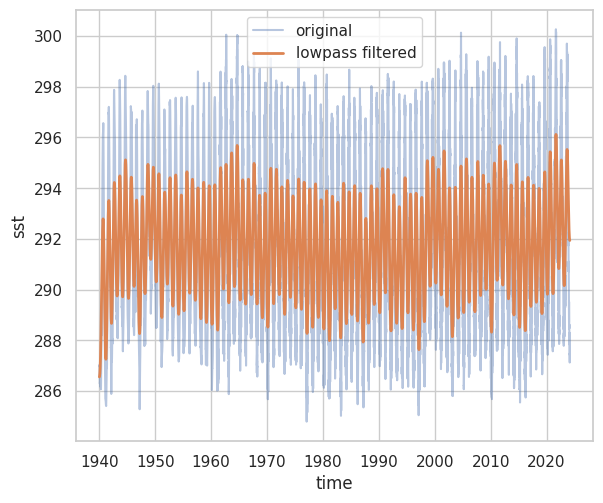

In [11]:
# Low-pass filter
fc = 1/365  # cutoff frequency of 1 year
Wn = fc / (fs / 2)  # critical frequency for butterworth filter
N = 2  # filter order
b, a = butter(N, Wn, btype="lowpass")
yfilt_low = filtfilt(b, a, climate['sst'])

# Plot the result
fig, ax = plt.subplots()
ax.plot(climate['time'], climate['sst'], alpha=0.4, label="original")
ax.plot(climate['time'], yfilt_low, linewidth=2, label="lowpass filtered")
ax.set_xlabel("time")
ax.set_ylabel("sst")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)

### Calculate the discrete fourier transform from the filtered data

In [12]:
# Calculating the discrete fourier transform using Numpy's FFT implementation
dft = np.fft.fft(yfilt_low)[:p + 1]
P_from_dft = (np.real(dft)**2 + np.imag(dft)**2) / n

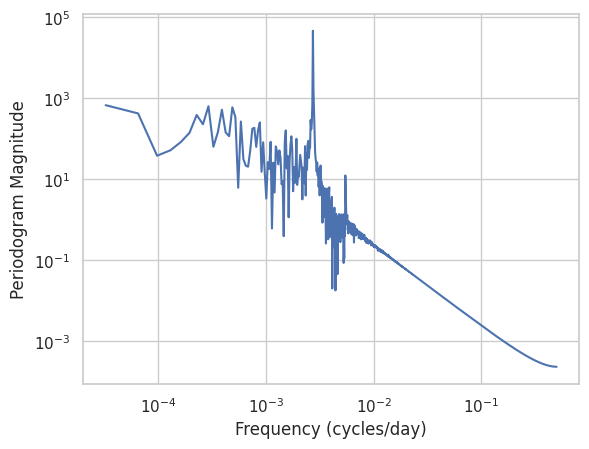

In [13]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(frequency[1:], P_from_dft[1:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

###What are the most prominent trends greater than a year?

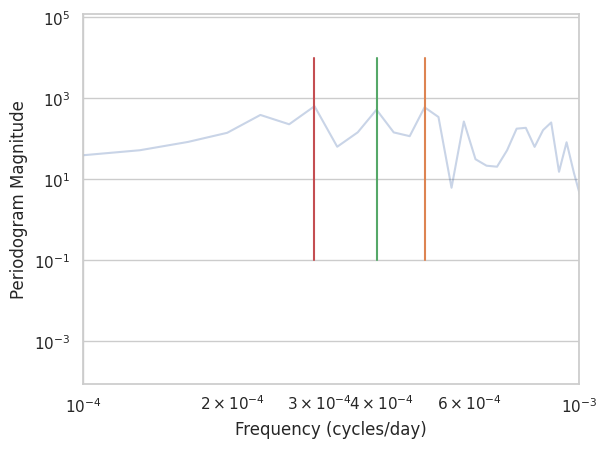

In [14]:
# Guess and check lines
num_years_1 = 5.6
num_years_2 = 7
num_years_3 = 9.4
x1 = np.array([1/(num_years_1*365) for _ in range(3)])
x2 = np.array([1/(num_years_2*365) for _ in range(3)])
x3 = np.array([1/(num_years_3*365) for _ in range(3)])
y = np.array([10**-1, 1, 10**4])

# Plotting
fig, ax = plt.subplots()
ax.plot(frequency[1:], P_from_dft[1:], alpha=0.3)
ax.plot(x1, y)
ax.plot(x2, y)
ax.plot(x3, y)
ax.set_xlim(10**-4, 10**-3)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

Using guess and check again on a zoomed in version of the periodogram, the most prominent trends exist at 5.6, 7, and 9.4 years.

### Forecasting
For forecasting, we'll be using a lagged auoregression model.

In [15]:
# Rename filtered data to climate
climate = yfilt_low

In [16]:
# Number of years to forecast into the future
forecast_years = 20
# Number of days to forecast into the future
forecast_days = 365*forecast_years

#### Train-test split

In [17]:
# Split based on the number of days to forecast into the future
last_train_index = len(climate)-forecast_days
climate_train = climate[:last_train_index]
climate_test = climate[last_train_index:]

### Find best lag
Find the lag k (in days) that results in the smallest mse on the test data set.

In [18]:
# Takes in train and test data tries different lags (k) from
# 1 to forecast_days days to find the linear regression model
# with the lowest mae on the test data.
# Returns a tuple containing the best model, the of that model using the
# testing data prediciton, the best mae, and the best k.
def find_best_lag(train, test, forecast_days):
  best_reg = None
  best_predict = None
  best_mae = None
  best_k = None
  for k in range(1, forecast_days):
    predictor_train = train[:-k]
    predictor_train = np.reshape(predictor_train, (-1,1))
    response_train = train[k:]
    response_train = np.reshape(response_train, (-1,1))

    predictor_test = test[:-k]
    predictor_test = np.reshape(predictor_test, (-1,1))
    response_test = test[k:]
    response_test = np.reshape(response_test, (-1,1))

    reg = LinearRegression().fit(predictor_train, response_train)
    prediction = reg.predict(predictor_test)
    mae = np.nanmean(np.abs(prediction - response_test))

    if best_mae is None or mae < best_mae:
      best_mae = mae
      best_predict = prediction
      best_reg = reg
      best_k = k

  return (best_reg, best_predict, best_mae, best_k)

In [19]:
reg, climate_predicted, mae, k = find_best_lag(climate_train, climate_test, forecast_days)
print(f"Best MAE was {mae:.2f} with best k {k}")

Best MAE was 0.03 with best k 1


A best k of 1 day? That's a little... disapointing.

###Plot the results on the test data

In [20]:
# Get a list of datetimes for every day since 1/1/1940
start_date = datetime(1940, 1, 1)
time = [start_date + timedelta(days=int(day)) for day in range(len(climate))]

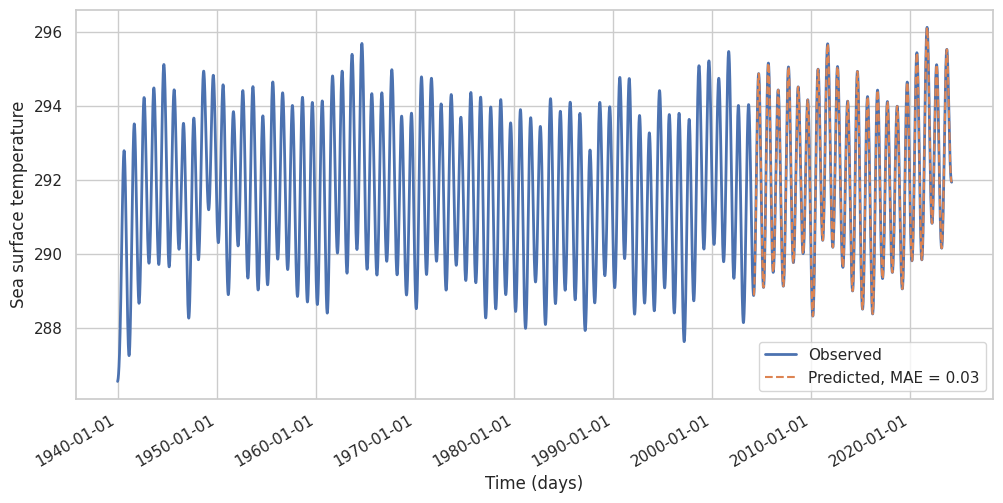

In [21]:
# Plotting
fig, ax = plt.subplots()
ax.plot(time, climate, '-', linewidth=2, label="Observed")
ax.plot(time[len(time)-len(climate_predicted):], climate_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (days)")
ax.set_ylabel("Sea surface temperature")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

It appears to model the test data very well, making it seem like a worthwhile model to predict the actual future.

### Forecast into the (actual) future
Use the test data to predict 20 years into the future.

In [22]:
# Predict 20 years into the future using the test data
climate_last = np.reshape(climate_test[:-k], (-1,1))
climate_future_prediction = reg.predict(climate_last)

In [23]:
# Create the time list for the future predictions
future_time = [time[-1] + timedelta(days=int(day)) for day in range(len(climate_future_prediction))]

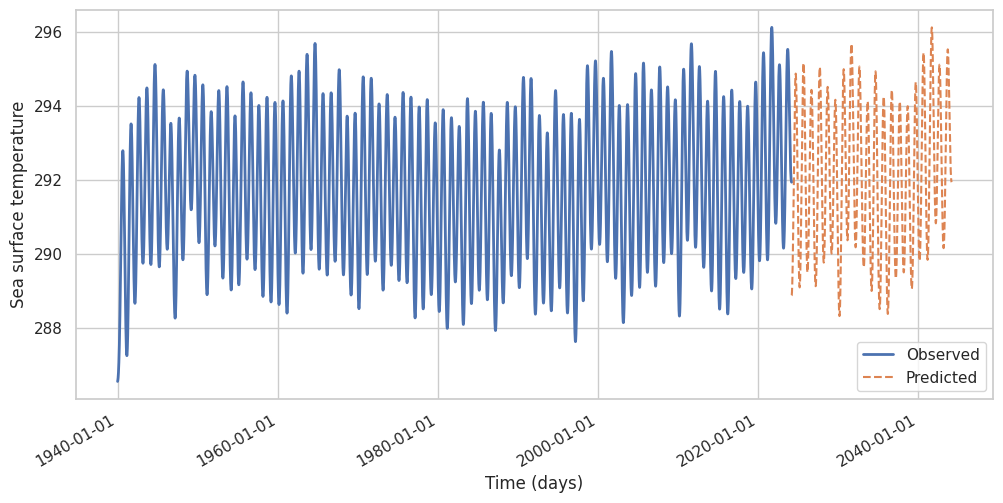

In [24]:
# Plot observed and future predictions
fig, ax = plt.subplots()
ax.plot(time, climate, '-', linewidth=2, label="Observed")
ax.plot(future_time, climate_future_prediction, '--', label="Predicted")
ax.legend()
ax.set_xlabel("Time (days)")
ax.set_ylabel("Sea surface temperature")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

It doesn't look noticeably bad, and also seems to have slightly higher peaks and troughs than the rest of the data set. This in in-line with what we might expect as a result of climate change.

## Conclusion
A year and a half-year are by far the most prevalent frequencies in the North Pacific sea surface temperatures. But by using a butterworth filter to perform lowpass filtering with a cutoff frequency of a 1/year, we were able to identify the prominent trends of 5.6, 7, and 9.4 years with less noise. Additionally, when attempting to predict 20 years into the future, an autoregression model has the lowest mse on the testing data with a k/lag of just 1. It resulted in an mse of 0.03, which is remarkably good. This puts some confidence into the model's predictive power on the actual future, which appears to gently trend upward.